# Data Preparation

In [144]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt
# import featuretools as ft

# Read Data from CSV file

In [145]:
df = pd.read_csv("./data/sample_data.csv", delimiter='\t')
df.head()

,Date,Time,Open,High,Low,Close,Volume
0,28/02/2022,00:00:00,2616.79,2625.79,2590.00,2605.72,26402.6539
1,28/02/2022,01:00:00,2605.72,2680.00,2604.71,2643.84,37865.7582
2,28/02/2022,02:00:00,2643.82,2653.55,2592.29,2612.67,26263.9856
3,28/02/2022,03:00:00,2612.66,2620.77,2599.77,2608.05,13132.6801
4,28/02/2022,04:00:00,2608.05,2632.99,2602.20,2611.03,12625.9574


# verify data

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    169 non-null    object 
 1   Time    169 non-null    object 
 2   Open    169 non-null    float64
 3   High    169 non-null    float64
 4   Low     169 non-null    float64
 5   Close   169 non-null    float64
 6   Volume  169 non-null    float64
dtypes: float64(5), object(2)
memory usage: 9.4+ KB


In [147]:
df.index = df.index.astype(int)

# Data Cleaning

For null data we decide to replace it with next record of data because With this method, we maintain the increasing or decreasing trend of the flow

In [148]:
# Fill null values with next record value
df.fillna(method='ffill', inplace=True)

# Drop rows with null values at the end
df.dropna(axis=0, how='any', inplace=True)

Delete duplicated records

In [149]:
df.drop_duplicates(inplace=True)

Correcting Data Types:

In [150]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Time']).dt.time
df['Open'] = df['Open'].astype(float) 
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)

C:\Users\pedra\AppData\Local\Temp\ipykernel_21004\4291731452.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date']).dt.date
C:\Users\pedra\AppData\Local\Temp\ipykernel_21004\4291731452.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.time


detectiong outline fieldes
we use Zscore method to recugenise outline values 
at this method we calculate Zscore value of each field and if they are bigger than +3 or smaller than -3 we replace the field value with previos record

In [151]:
df['Open_Zscore'] = stats.zscore(df['Open'])
df['High_Zscore'] = stats.zscore(df['High'])
df['Low_Zscore'] = stats.zscore(df['Low'])
df['Volume_Zscore'] = stats.zscore(df['Volume'])

threshold = 3

outliers_open = df[df['Open_Zscore'].abs() > threshold]
outliers_high = df[df['High_Zscore'].abs() > threshold]
outliers_low = df[df['Low_Zscore'].abs() > threshold]
outliers_volume = df[df['Volume_Zscore'].abs() > threshold]


Replace the outline fields with the value of previous record

In [152]:
for idx in outliers_open.index:
    df.at[idx, 'Open'] = df.at[idx-1, 'Open']

for idx in outliers_high.index:
    df.at[idx, 'High'] = df.at[idx-1, 'High']

for idx in outliers_low.index:
    df.at[idx, 'Low'] = df.at[idx-1, 'Low']

for idx in outliers_volume.index:
    # print(df.at[idx, 'Volume'])
    # print(df.at[idx-1, 'Volume'])
    df.at[idx, 'Volume'] = df.at[idx-1, 'Volume']

# Drop Z-score columns
df.drop(['Open_Zscore', 'High_Zscore', 'Low_Zscore', 'Volume_Zscore'], axis=1, inplace=True)

# Optionally, you can choose to visualize or print the DataFrame to verify the changes
print(df)

           Date      Time     Open     High      Low    Close  Volume
0    2022-02-28  00:00:00  2616.79  2625.79  2590.00  2605.72   26402
1    2022-02-28  01:00:00  2605.72  2680.00  2604.71  2643.84   37865
2    2022-02-28  02:00:00  2643.82  2653.55  2592.29  2612.67   26263
3    2022-02-28  03:00:00  2612.66  2620.77  2599.77  2608.05   13132
4    2022-02-28  04:00:00  2608.05  2632.99  2602.20  2611.03   12625
..          ...       ...      ...      ...      ...      ...     ...
164  2022-03-06  20:00:00  2607.03  2622.99  2604.04  2617.49   12171
165  2022-03-06  21:00:00  2617.48  2643.42  2613.46  2629.48   17034
166  2022-03-06  22:00:00  2629.49  2644.45  2626.45  2629.09    7328
167  2022-03-06  23:00:00  2629.08  2632.43  2535.00  2551.29   50781
168  2022-03-07  00:00:00  2551.30  2555.56  2512.50  2542.37   42418

[169 rows x 7 columns]


In [153]:
# df['datetime']= df['Date']+' '+df['Time']
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

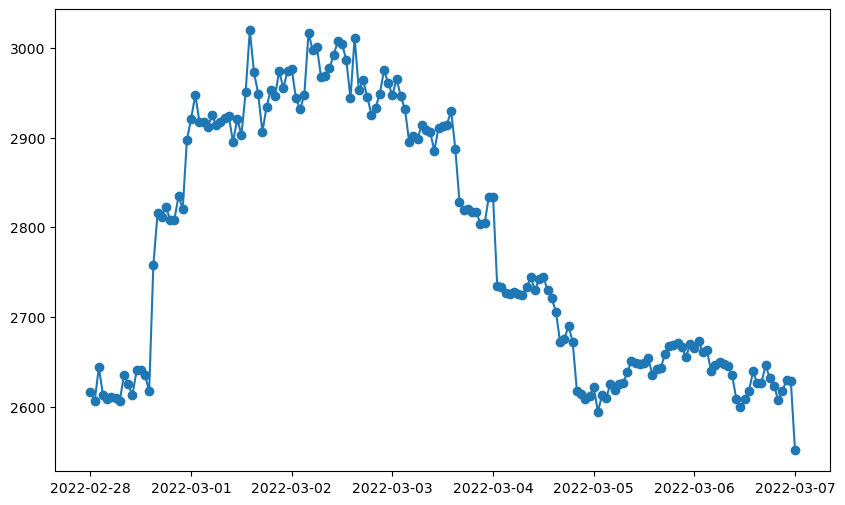

In [154]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['Open'], marker='o', linestyle='-')

#Feature Engineering

For analyzing crypto curencies we will use Ichimoko Algoritm and for deploying ichimoko we should add som features to our Data Frame

calculate and add Tenkan_sen

In [155]:
df['Highest'] = df['High'].rolling(window=9).max()
df['Lowest'] = df['Low'].rolling(window=9).min()

df['Tenkan_sen'] = (df['Highest'] + df['Lowest']) / 2

df.drop(columns=['Highest'], inplace=True)
df.drop(columns=['Lowest'], inplace=True)

calculate and add Kijun_sen

In [156]:
df['Highest'] = df['High'].rolling(window=26).max()
df['Lowest'] = df['Low'].rolling(window=26).min()


df['Kijun_sen'] = (df['Highest'] + df['Lowest']) / 2
df.drop(columns=['Highest'], inplace=True)
df.drop(columns=['Lowest'], inplace=True)


calculate and add Chikou_span

In [157]:
df['Chikou_span'] = df['Close'].shift(26)

In [158]:
df.head(50)

,Date,Time,Open,High,Low,Close,Volume,datetime,Tenkan_sen,Kijun_sen,Chikou_span
0,2022-02-28,00:00:00,2616.79,2625.79,2590.00,2605.72,26402,2022-02-28 00:00:00,NaN,NaN,NaN
1,2022-02-28,01:00:00,2605.72,2680.00,2604.71,2643.84,37865,2022-02-28 01:00:00,NaN,NaN,NaN
2,2022-02-28,02:00:00,2643.82,2653.55,2592.29,2612.67,26263,2022-02-28 02:00:00,NaN,NaN,NaN
3,2022-02-28,03:00:00,2612.66,2620.77,2599.77,2608.05,13132,2022-02-28 03:00:00,NaN,NaN,NaN
4,2022-02-28,04:00:00,2608.05,2632.99,2602.20,2611.03,12625,2022-02-28 04:00:00,NaN,NaN,NaN
5,2022-02-28,05:00:00,2611.02,2624.12,2603.08,2610.14,13318,2022-02-28 05:00:00,NaN,NaN,NaN
6,2022-02-28,06:00:00,2610.14,2630.92,2568.62,2606.50,37473,2022-02-28 06:00:00,NaN,NaN,NaN
7,2022-02-28,07:00:00,2606.50,2653.75,2598.12,2635.32,29038,2022-02-28 07:00:00,NaN,NaN,NaN
8,2022-02-28,08:00:00,2635.32,2658.00,2617.00,2625.34,19087,2022-02-28 08:00:00,2624.310,NaN,NaN
9,2022-02-28,09:00:00,2625.34,2642.58,2612.36,2612.39,13837,2022-02-28 09:00:00,2624.310,NaN,NaN


Print Graph to view the important features

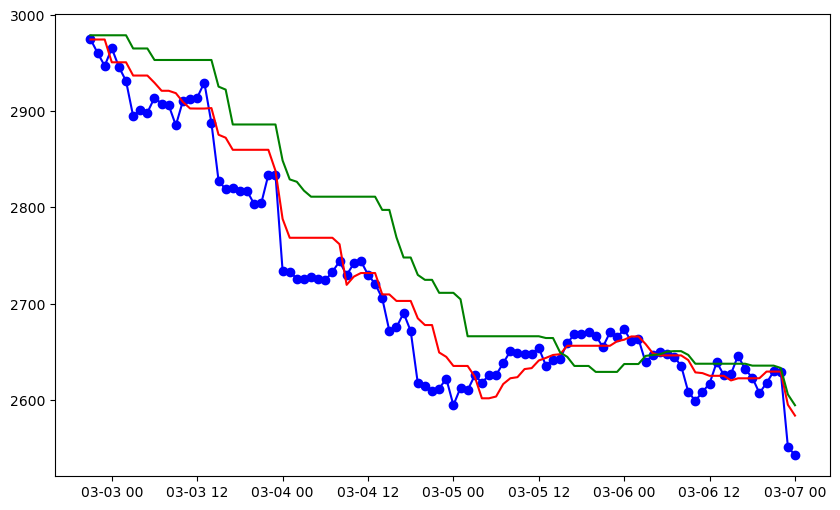

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'].iloc[-100:], df['Close'].iloc[-100:], marker='o', linestyle='-',color='blue')
plt.plot(df['datetime'].iloc[-100:], df['Tenkan_sen'].iloc[-100:], linestyle='-',color='red' )
plt.plot(df['datetime'].iloc[-100:], df['Kijun_sen'].iloc[-100:], linestyle='-',color='green' )


